### Data Cleaning

Your mission, should you choose to accept it, is to write a preprocessing function for all of your text. This functions should

- remove punctuation,
- stem or lemmatize each word of the text,
- remove stopwords


In [1]:
#EDA 
import pandas as pd 
import numpy as np   

#NLP
import regex as re
import nltk

#Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns

#Modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

np.random.seed(42)

#Warnings - to keep the notebook clean 
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns= 5000

In [2]:
#I will clean from the CSV so I don't have to rerun the webscraping each time 
reddit = pd.read_csv('./combined_reddit_data.csv')

In [3]:
#Check the datatypes
reddit.dtypes

selftext        object
title           object
domain          object
created_utc      int64
num_comments     int64
subreddit       object
is_self           bool
timestamp       object
dtype: object

In [4]:
reddit.head()

,selftext,title,domain,created_utc,num_comments,subreddit,is_self,timestamp
0,NaN,"Need to wash off grease, tree sap, oil, etc. b...",self.LifeProTips,1551621508,1,LifeProTips,True,2019-03-03
1,If you booked an airline ticket that charges c...,Airline Bag Fee Saving Tip,self.LifeProTips,1551622211,1,LifeProTips,True,2019-03-03
2,[removed],Need to scan some documents but don’t have a s...,self.LifeProTips,1551622439,2,LifeProTips,True,2019-03-03
3,NaN,"LPT Need to wash off grease, tree sap, oil, et...",self.LifeProTips,1551622542,2,LifeProTips,True,2019-03-03
4,NaN,LPT: When microwaving leftover rice put a glas...,self.LifeProTips,1551622755,928,LifeProTips,True,2019-03-03


In [5]:
#Function to clean data/ pre-processing 

def clean_text(df):
    
    df = df[df['selftext'] != '[removed]']                              
    #remove the selftexts that were removed by reddit. 
    #I pulled enough data from the API to get rid of these and still have statistical significance 
    
    df['selftext'].fillna(value= 'No subtext', inplace=True)            
    #Change selftext NaN to empty string 
    
    df['fulltext'] = df['title'] + ' ' + df['selftext']                 
    #Combine selftext & title into one column 
    
    df['subreddit'] = df['subreddit'].map({'LifeProTips':1,'explainlikeimfive':0})
    #Change subreddit column to be a boolean number 
    
    df['fulltext'] = [str(words).lower() for words in df['fulltext']]    
    #Change all the text to lowercase 
    
    df['fulltext'] = [(re.sub(r'[^\w\s]','', word)) for word in df['fulltext']]
    #remove puncutation. Got this regex code from stack overflow, checked it in regex101.com and put it in a list comp
    
    return df

In [6]:
#Apply the cleaning function to the reddit csv and rename as a different dataframe 
df = clean_text(reddit)

In [7]:
df.head()

,selftext,title,domain,created_utc,num_comments,subreddit,is_self,timestamp,fulltext
0,No subtext,"Need to wash off grease, tree sap, oil, etc. b...",self.LifeProTips,1551621508,1,1,True,2019-03-03,need to wash off grease tree sap oil etc but d...
1,If you booked an airline ticket that charges c...,Airline Bag Fee Saving Tip,self.LifeProTips,1551622211,1,1,True,2019-03-03,airline bag fee saving tip if you booked an ai...
3,No subtext,"LPT Need to wash off grease, tree sap, oil, et...",self.LifeProTips,1551622542,2,1,True,2019-03-03,lpt need to wash off grease tree sap oil etc b...
4,No subtext,LPT: When microwaving leftover rice put a glas...,self.LifeProTips,1551622755,928,1,True,2019-03-03,lpt when microwaving leftover rice put a glass...
9,No subtext,LPT Take an empty notebook and try to find a p...,self.LifeProTips,1551626665,9,1,True,2019-03-03,lpt take an empty notebook and try to find a p...


In [ ]:
#Lemmatize
lm= WordNetLemmatizer()

df['fulltext'] = [" ".join([lm.lemmatize(w) for w in i.split()]) for i in df['fulltext']]

In [8]:
#Check that the changes worked 
df.head()

,selftext,title,domain,created_utc,num_comments,subreddit,is_self,timestamp,fulltext
0,No subtext,"Need to wash off grease, tree sap, oil, etc. b...",self.LifeProTips,1551621508,1,1,True,2019-03-03,need to wash off grease tree sap oil etc but d...
1,If you booked an airline ticket that charges c...,Airline Bag Fee Saving Tip,self.LifeProTips,1551622211,1,1,True,2019-03-03,airline bag fee saving tip if you booked an ai...
3,No subtext,"LPT Need to wash off grease, tree sap, oil, et...",self.LifeProTips,1551622542,2,1,True,2019-03-03,lpt need to wash off grease tree sap oil etc b...
4,No subtext,LPT: When microwaving leftover rice put a glas...,self.LifeProTips,1551622755,928,1,True,2019-03-03,lpt when microwaving leftover rice put a glass...
9,No subtext,LPT Take an empty notebook and try to find a p...,self.LifeProTips,1551626665,9,1,True,2019-03-03,lpt take an empty notebook and try to find a p...


### Define Target and Features 

In [9]:
X = df['fulltext']
y = df['subreddit']

### Train Test Split 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state =42, 
                                                    stratify = y)

In [11]:
# Check the baseline 
# Also check to see the balanced class

y.value_counts(normalize = True )

0    0.526846
1    0.473154
Name: subreddit, dtype: float64

### Baseline Model - default parameters 

In [12]:
#My first model will the baseline model, therefore I do not need a pipeline or gridsearch here. 
#I will instantiate and fit a regualr CountVecotrizer model and leave the default parameters

cvec = CountVectorizer()
cvec.fit(X_train, y_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)

#Print scores 
print(f'Logreg train score:{logreg.score(X_train_cvec, y_train)}')
print(f'Logreg test score: {logreg.score(X_test_cvec, y_test)}')
print(f'Logreg cv score: {cross_val_score(logreg, X_train_cvec, y_train, cv=5).mean()}')


Logreg train score:0.9997683039851715
Logreg test score: 0.985406532314107
Logreg cv score: 0.9881839779189544


### What does a 99% score on the train data mean? 

Given the nearly perfect score on the train data, I need to dig deeper into the fulltext. 
- My baseline model is very good with the default parameters
- This is most likely due to the keywords in the title: "lpt" and "eli5" 
- This text at the start of every subreddit title is most likely a requirement from the subreddit
- In the model, it helps identify each subreddit very accurately 

Based on the above, I would like to remove these keywords to re-run the baseline model and for all models going forward. 

In [13]:
def remove_keywords(text):
    df['fulltext'] = df['fulltext'].map(lambda x: x.replace('lpt', " "))
    df['fulltext'] = df['fulltext'].map(lambda x: x.replace('eli5', " "))
    df['fulltext'] = df['fulltext'].map(lambda x: x.replace('subtext', " "))    #also want to remove the word subtext since I combined the columns 
    return text

In [14]:
df['fulltext'] = remove_keywords(df['fulltext'])

In [15]:
df['fulltext'].head()

0    need to wash off grease tree sap oil etc but d...
1    airline bag fee saving tip if you booked an ai...
3      need to wash off grease tree sap oil etc but...
4      when microwaving leftover rice put a glass o...
9      take an empty notebook and try to find a pro...
Name: fulltext, dtype: object

### Re-run the baseline model without the keywords in the data

In [16]:
X = df['fulltext']
y = df['subreddit']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state =42, 
                                                    stratify = y)

In [18]:
#Same code as above

cvec = CountVectorizer()
cvec.fit(X_train, y_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)

#Print scores 
print(f'Logreg train score:{logreg.score(X_train_cvec, y_train)}')
print(f'Logreg test score: {logreg.score(X_test_cvec, y_test)}')
print(f'Logreg cv score: {cross_val_score(logreg, X_train_cvec, y_train, cv=5).mean()}')

Logreg train score:0.9988415199258572
Logreg test score: 0.9589993050729674
Logreg cv score: 0.9557489304951015


After removing the keywords, the scores did decreases slighty. Next, I will build a pipeline and gridsearch to tune the hyper parameters and try to improve the test score.

In [19]:
# Create empty lists & function in order to plot the scores at the end 
train_scores = []
test_scores = []

def record_scores(list_name, score):
    list_name.append(score)


In [20]:
record_scores(train_scores, logreg.score(X_train_cvec, y_train))
record_scores(test_scores, logreg.score(X_test_cvec, y_test))

print(train_scores)
print(test_scores)

[0.9988415199258572]
[0.9589993050729674]


# Optimize Model to find the Best Parameters

### Pipeline 

In [21]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('logreg', LogisticRegression())
])

pipe

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

### Gridsearch

In [22]:
# Tune GridSearchCV
pipe_params = {
    'cvec__stop_words': [None],             
    'cvec__max_features': [5000, 10000],                      
    'cvec__ngram_range': [(1,2)],
    'logreg__penalty':['l1'],
    'logreg__C' : np.logspace(1, 5, 3), 
    'logreg__n_jobs' : [-2]
}

gs = GridSearchCV(pipe, param_grid = pipe_params, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__stop_words': [None], 'cvec__max_features': [5000, 10000], 'cvec__ngram_range': [(1, 2)], 'logreg__penalty': ['l1'], 'logreg__C': array([1.e+01, 1.e+03, 1.e+05]), 'logreg__n_jobs': [-2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Scores

In [23]:
print(gs.best_score_)
(gs.best_params_)

0.9552826691380908


{'cvec__max_features': 10000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logreg__C': 10.0,
 'logreg__n_jobs': -2,
 'logreg__penalty': 'l1'}

In [24]:
print(f'GridSearch train score: {gs.score(X_train, y_train)}')
print(f'GridSearch test score: {gs.score(X_test, y_test)}')

GridSearch train score: 0.9995366079703429
GridSearch test score: 0.9583043780403058


In [25]:
#Record scores 
record_scores(train_scores, gs.score(X_train, y_train))
record_scores(test_scores, gs.score(X_test, y_test))

print(train_scores)
print(test_scores)

[0.9988415199258572, 0.9995366079703429]
[0.9589993050729674, 0.9583043780403058]


In [26]:
#Able to see all the results in a dataframe 
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__ngram_range,param_cvec__stop_words,param_logreg__C,param_logreg__n_jobs,param_logreg__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,0.534198,0.007405,0.118027,0.000913,10000,"(1, 2)",None,10,-2,l1,"{'cvec__max_features': 10000, 'cvec__ngram_ran...",0.956220,0.947186,0.962448,0.955283,0.006266,1,1.0,0.999305,0.999305,0.999537,0.000328
0,0.597490,0.016284,0.128673,0.004720,5000,"(1, 2)",None,10,-2,l1,"{'cvec__max_features': 5000, 'cvec__ngram_rang...",0.954135,0.944406,0.963143,0.953892,0.007651,2,1.0,0.999305,0.999305,0.999537,0.000328
4,0.524912,0.008078,0.115552,0.000715,10000,"(1, 2)",None,1000,-2,l1,"{'cvec__max_features': 10000, 'cvec__ngram_ran...",0.944406,0.951355,0.960362,0.952039,0.006531,3,1.0,0.999652,0.999653,0.999768,0.000164
1,0.606344,0.008967,0.134777,0.021585,5000,"(1, 2)",None,1000,-2,l1,"{'cvec__max_features': 5000, 'cvec__ngram_rang...",0.948575,0.940931,0.959666,0.949722,0.007691,4,1.0,0.999652,0.999653,0.999768,0.000164
2,0.539356,0.018920,0.114834,0.004573,5000,"(1, 2)",None,100000,-2,l1,"{'cvec__max_features': 5000, 'cvec__ngram_rang...",0.909659,0.909659,0.913074,0.910797,0.001609,5,1.0,0.999652,0.999653,0.999768,0.000164


# Try with TFIDF

In [27]:
pipe_t = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('logreg', LogisticRegression())
])

pipe_t

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [29]:
#Change to TFIDF params 
#how to tune max_features 

# Tune GridSearchCV
pipe_params_t = {
    'tfidf__stop_words': [None],              
    'tfidf__max_features': [15_000, 20_000],                 
    'tfidf__ngram_range': [(1,1), (1,2)],
    'logreg__penalty':['l2'],
    'logreg__C' : np.logspace(1, 5, 3), 
    'logreg__n_jobs' : [-2]
}

gs_t = GridSearchCV(pipe_t, param_grid = pipe_params_t, cv=3)
gs_t.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__stop_words': [None], 'tfidf__max_features': [15000, 20000], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'logreg__penalty': ['l2'], 'logreg__C': array([1.e+01, 1.e+03, 1.e+05]), 'logreg__n_jobs': [-2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
print(gs_t.best_score_)
(gs_t.best_params_)

0.9647822057460612


{'logreg__C': 10.0,
 'logreg__n_jobs': -2,
 'logreg__penalty': 'l2',
 'tfidf__max_features': 15000,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [31]:
print(f'GridSearch train score: {gs_t.score(X_train, y_train)}')
print(f'GridSearch test score: {gs_t.score(X_test, y_test)}')

GridSearch train score: 0.9993049119555144
GridSearch test score: 0.9638637943015983


In [32]:
#Record scores 
record_scores(train_scores, gs_t.score(X_train, y_train))
record_scores(test_scores, gs_t.score(X_test, y_test))

print(train_scores)
print(test_scores)

[0.9988415199258572, 0.9995366079703429, 0.9993049119555144]
[0.9589993050729674, 0.9583043780403058, 0.9638637943015983]


### Bayes with Cvec

In [33]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

pipe

Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [34]:
# Tune GridSearchCV
pipe_params = {
    'cvec__stop_words': [None, 'english'],             
    'cvec__max_features': [5000, 10_000],                      
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [0.1, 0.5, 1],
}

#Fit model 
gs = GridSearchCV(pipe, param_grid = pipe_params, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__stop_words': [None, 'english'], 'cvec__max_features': [5000, 10000], 'cvec__ngram_range': [(1, 1), (1, 2)], 'nb__alpha': [0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
print(gs.best_score_)
(gs.best_params_)

0.9610750695088045


{'cvec__max_features': 10000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'nb__alpha': 1}

In [36]:
print(f'GridSearch train score: {gs.score(X_train, y_train)}')
print(f'GridSearch test score: {gs.score(X_test, y_test)}')

GridSearch train score: 0.9844763670064874
GridSearch test score: 0.9603891591382905


In [37]:
#Record scores 
record_scores(train_scores, gs.score(X_train, y_train))
record_scores(test_scores, gs.score(X_test, y_test))

print(train_scores)
print(test_scores)

[0.9988415199258572, 0.9995366079703429, 0.9993049119555144, 0.9844763670064874]
[0.9589993050729674, 0.9583043780403058, 0.9638637943015983, 0.9603891591382905]


### Bayes with TFIDF

In [38]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('nb', MultinomialNB())
])

pipe

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [39]:
pipe_params = {
    'tfidf__stop_words': [None],              
    'tfidf__max_features': [20_000],                 
    'tfidf__ngram_range': [(1,4), (1,5)],
    'nb__alpha': [3,4],
}

gs = GridSearchCV(pipe, param_grid = pipe_params, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__stop_words': [None], 'tfidf__max_features': [20000], 'tfidf__ngram_range': [(1, 4), (1, 5)], 'nb__alpha': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print(gs.best_score_)
(gs.best_params_)

0.9615384615384616


{'nb__alpha': 3,
 'tfidf__max_features': 20000,
 'tfidf__ngram_range': (1, 4),
 'tfidf__stop_words': None}

In [41]:
print(f'GridSearch train score: {gs.score(X_train, y_train)}')
print(f'GridSearch test score: {gs.score(X_test, y_test)}')

GridSearch train score: 0.9833178869323448
GridSearch test score: 0.9589993050729674


In [42]:
#Record scores 
record_scores(train_scores, gs.score(X_train, y_train))
record_scores(test_scores, gs.score(X_test, y_test))

print(train_scores)
print(test_scores)

[0.9988415199258572, 0.9995366079703429, 0.9993049119555144, 0.9844763670064874, 0.9833178869323448]
[0.9589993050729674, 0.9583043780403058, 0.9638637943015983, 0.9603891591382905, 0.9589993050729674]


### Interpret Scores 

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
#Compare the scores in a Data Frame

scores_df = pd.DataFrame({'Train': train_scores, "Test": test_scores})

scores_df['score_diff'] = scores_df['Train'] - scores_df['Test']
scores_df['model_name'] = ['Cvec-Logreg','Cvec-Logreg','Tfidf-Logreg','Cvec-NB','Tfidf-NB']

scores_df
# scores_df.map{0:'Cvec-Logreg',1:'Cvec-Logreg', 2:'Tfidf-Logreg', 3:'Cvec-NB', 4:'Tfidf-NB'})

,Train,Test,score_diff,model_name
0,0.998842,0.958999,0.039842,Cvec-Logreg
1,0.999537,0.958304,0.041232,Cvec-Logreg
2,0.999305,0.963864,0.035441,Tfidf-Logreg
3,0.984476,0.960389,0.024087,Cvec-NB
4,0.983318,0.958999,0.024319,Tfidf-NB


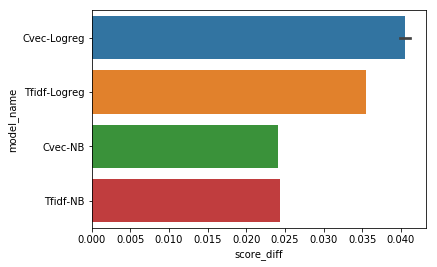

In [45]:
#Plot the score differences so it's easier to see 

sns.barplot(x='score_diff', y ='model_name', data = scores_df);

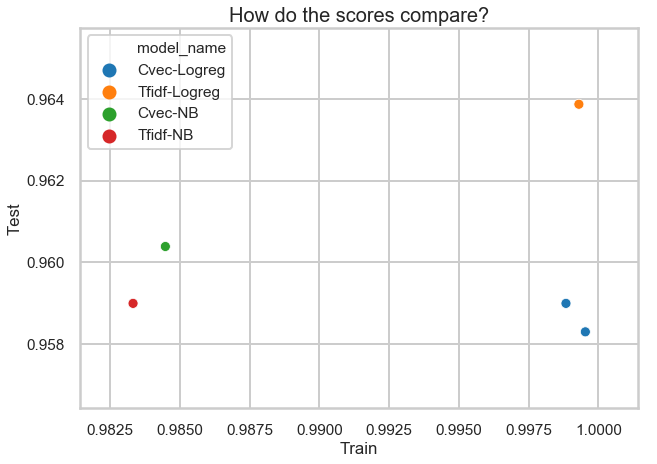

In [46]:
#Plot the train and test scores 

plt.figure(figsize = (10, 7))
sns.set_style("whitegrid")
sns.set_context("poster", font_scale = .7)
plt.title('How do the scores compare?', fontsize = 20)
sns.scatterplot(x= 'Train', y= 'Test', hue = 'model_name', data =scores_df, s=100);

### Final Model Choice:  Logistic Regression with TFIDF

### Predictions 

In [47]:
#Predictions 
predictions = gs_t.predict(X_test)

# Create DataFrame with column for predicted values
results = pd.DataFrame({'predicted': predictions, 
                        'actual': y_test,
                        'text': X_test})

#Find the rows with incorrect predictions 
misclass = results[results['predicted'] != results['actual']]
misclass.head()

,predicted,actual,text
7713,1,0,different servers for accessing facebook www...
2143,0,1,inside and cant tell ifhow hard its raining ...
8110,1,0,furnished holiday let uk no
604,0,1,the point of a debate isnt to be right its t...
7300,1,0,would a specific amendment to the constitut...


### Confusion Matrix 

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
confusion_matrix(y_test, 
                 predictions) 

#Here we can see that there are 52 misclassified predictions 

array([[730,  28],
       [ 24, 657]])

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [51]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 730
False Positives: 28
False Negatives: 24
True Positives: 657


In [52]:
#Calculate the Classification metrics 

accuracy = (tp+tn)/(tp+tn+fp+fn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp) 

print(f'Accuracy: {round(accuracy,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')
print(f'Specificity: {round(specificity,4)}')

Accuracy: 0.9639
Sensitivity: 0.9648
Specificity: 0.9631


### Probabilities of Coefficients 

In [54]:
data_coef = gs_t.best_estimator_.named_steps['logreg'].coef_
np.exp(data_coef)

array([[0.77202624, 1.91093966, 0.93674295, ..., 2.71900483, 1.50499836,
        1.13800814]])

In [55]:
#Got this function from stack overflow 

def get_top_n_words(corpus, n=None):                                            
#     List the top n words in a vocabulary according to occurrence in a text corpus.
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [56]:
#Apply the function to the data 

top_words = get_top_n_words(df['fulltext'], n=None)

In [57]:
#Make a df that only has LPT 

lpt = df[df['subreddit'] == 1]
lpt = get_top_n_words(lpt['fulltext'])

#Make a df that only has ELI5 

eli5 = df[df['subreddit'] == 0]
eli5 = get_top_n_words(eli5['fulltext'])

In [58]:
lpt_df = pd.DataFrame(data = lpt, columns= ('words', 'count')).head(10)

In [59]:
eli5_df = pd.DataFrame(data = eli5, columns= ('words', 'count')).head(10)

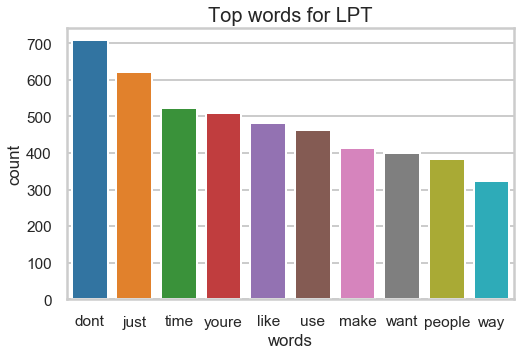

In [60]:
plt.figure(figsize = (8, 5))
sns.set_context("poster", font_scale = .7)
plt.title('Top words for LPT', fontsize = 20)
sns.barplot(x='words', y ='count', data = lpt_df );

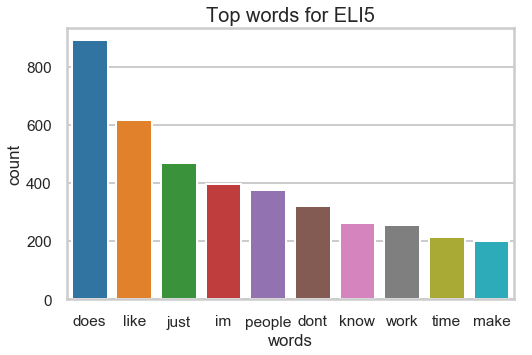

In [61]:
plt.figure(figsize = (8, 5))
sns.set_context("poster", font_scale = .7)
plt.title('Top words for ELI5', fontsize = 20)
sns.barplot(x='words', y ='count', data = eli5_df);